In [1]:
rm(list=ls())
set.seed(42)

library(tidyverse)
library(BayesianTools)
library(binom)
library(plyr)
library(deSolve)
library(coda)
library(lubridate)
theme_set(theme_minimal())

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object i

## Data prep ##

In [2]:
data <- read.csv("https://raw.githubusercontent.com/Stijn-A/RSV_serology/master/data/infection_status_csv.txt",
                 sep=",")

In [3]:
# Group age into intervals 
# bi-monthly for 0-2 years and 6-monthly for 2-5 years
data$agegrp <- cut(data$age_days,
                    breaks=c(seq(0,730, by=30.25*2),
                             seq(909,2000, by=30.25*6)), 
                    include.lowest = T, right=F)
# Divide by season of birth
spring <- c(3, 4, 5)
summer <- c(6, 7, 8)
autumn <- c (9, 10, 11)
winter <- c(1, 2, 12)

data <- data %>%
  mutate(
    Birth_mo = birthday %>% month()
  )%>%
  mutate(
    season_birth = case_when(
      Birth_mo %in% spring ~ "Spring",
      Birth_mo %in% summer ~ "Summer",
      Birth_mo %in% autumn ~ "Autumn",
      Birth_mo %in% winter ~ "Winter")
  )

In [4]:
spring <- subset(data, season_birth == "Spring")
young <- subset(spring, age_days < 9*30.41)
print(young$infection)

 [1] 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0


In [35]:
summer <- subset(data, season_birth == "Summer")
young <- subset(summer, age_days < 6*30.41)
print(young$infection)

 [1] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0


In [36]:
autumn <- subset(data, season_birth == "Autumn")
young <- subset(spring, age_days < 3*30.41)
print(young$infection)

 [1] 0 0 0 0 0 0 0 0 0 0 0 0


In [37]:
infected <- subset(data, infection == 1)
coucou <- min(infected$age_days)
print(coucou)

[1] 97


In [5]:
for (i in seq_along(data$age_days)){
    if ((data$season_birth[i] == "Spring") & (data$age_days[i] < 9*30.41)){
        data$infection[i] = 0
        }
    if ((data$season_birth[i] == "Summer") & (data$age_days[i] < 6*30.41)){
        data$infection[i] = 0
        }
    if ((data$season_birth[i] == "Autumn") & (data$age_days[i] < 3*30.41)){
        data$infection[i] = 0
    }
    }


In [6]:
spring <- subset(data, season_birth == "Spring")
young <- subset(spring, age_days < 9*30.41)
print(young$infection)

 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0


In [7]:
data_no_season <- data %>% dplyr::group_by(agegrp) %>% 
  dplyr::summarise(agemid=round(median(age_days)), # Age midpoint in age group
                   N=n(), # Total N in age group
                   nconv=sum(infection))

data <- data %>% dplyr::group_by(agegrp, season_birth) %>% 
  dplyr::summarise(agemid=round(median(age_days)), # Age midpoint in age group
                   N=n(), # Total N in age group
                   nconv=sum(infection)) # n seroconverted in age group


`summarise()` has grouped output by 'agegrp'. You can override using the `.groups` argument.


In [8]:
# Calculate seroprevalence and binomial confidence intervals
data[,c("seroprev_mean","seroprev_low95","seroprev_up95")] <- binom.confint(data$nconv, data$N, method="exact")[,c("mean","lower","upper")]
data_no_season[,c("seroprev_mean","seroprev_low95","seroprev_up95")] <- binom.confint(data_no_season$nconv, data_no_season$N, method="exact")[,c("mean","lower","upper")]

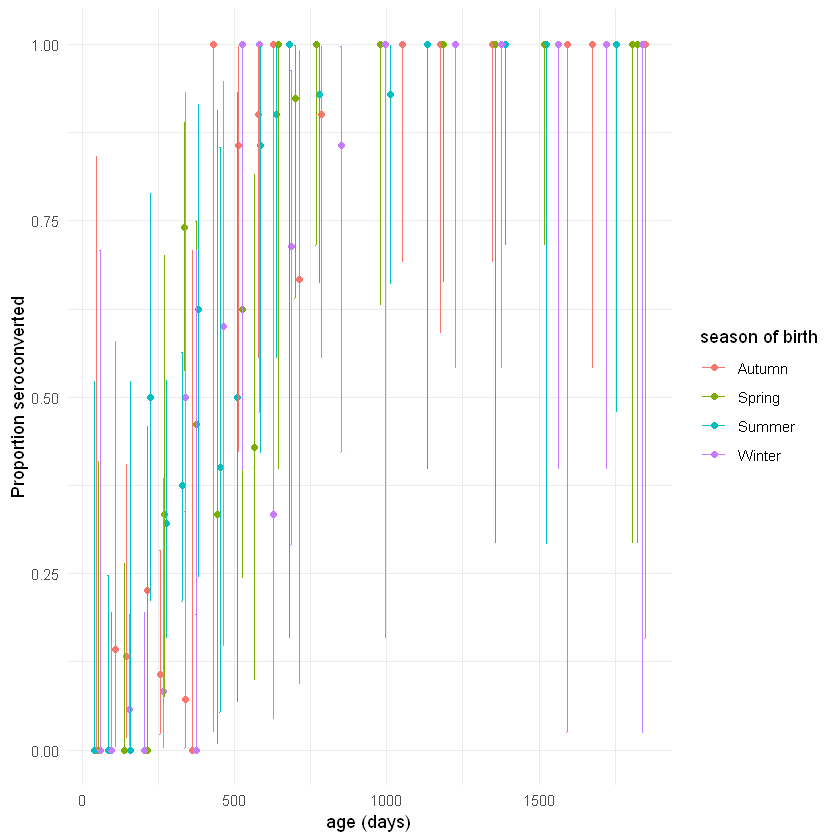

In [7]:
# Plot the whole data frame (difficult to read)
ggplot(data) +
  geom_point(aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(colour = "season of birth")

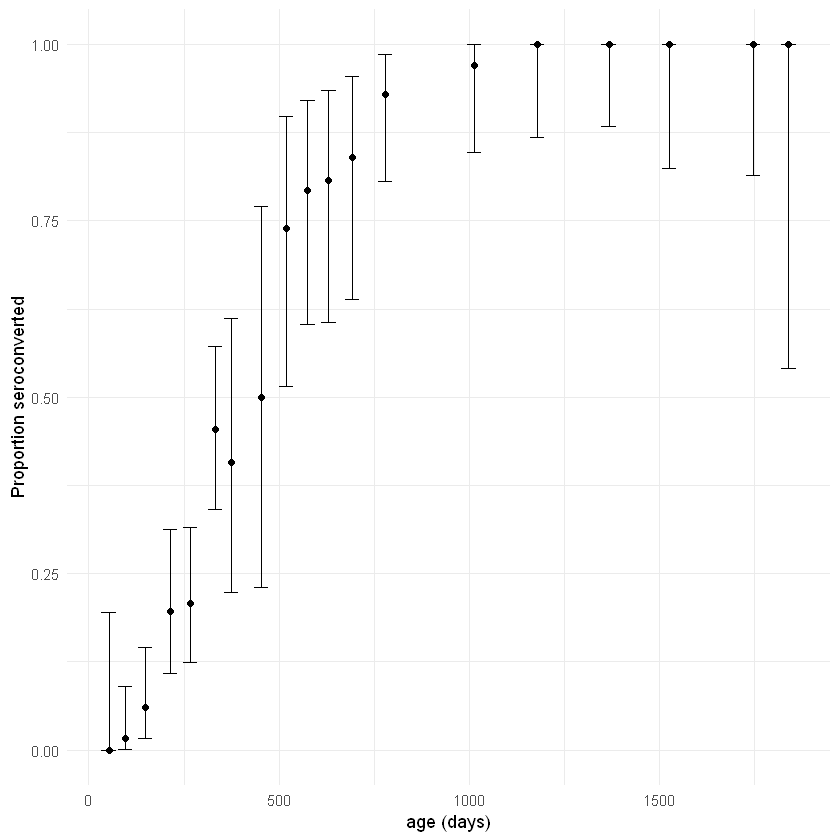

In [9]:
ggplot(data_no_season) +
  geom_point(aes(x=agemid, y=seroprev_mean)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  ylab("Proportion seroconverted") + xlab("age (days)") 

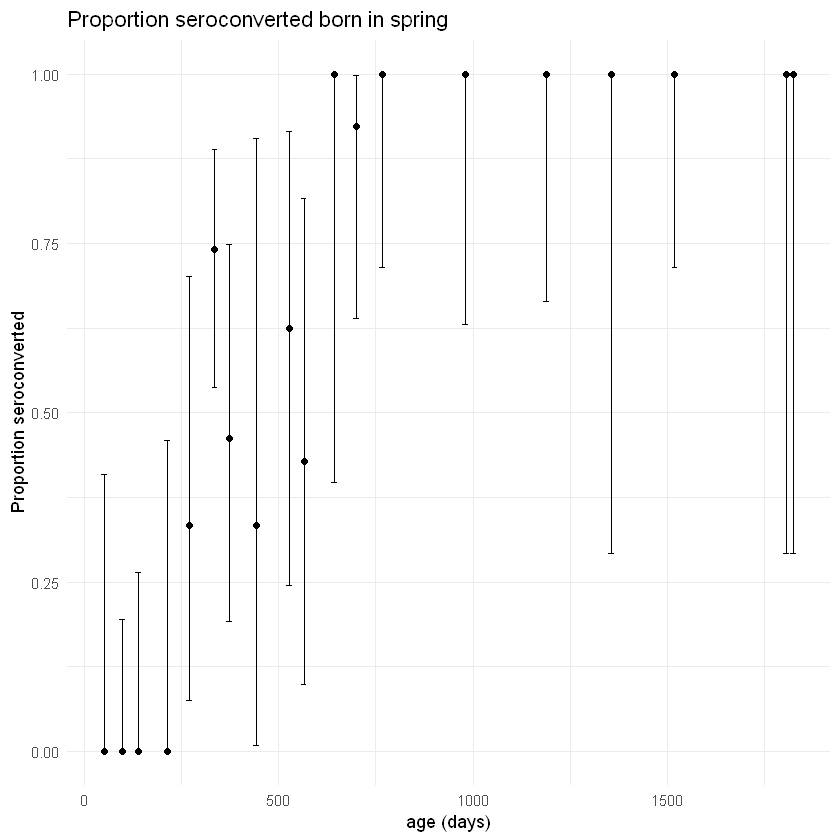

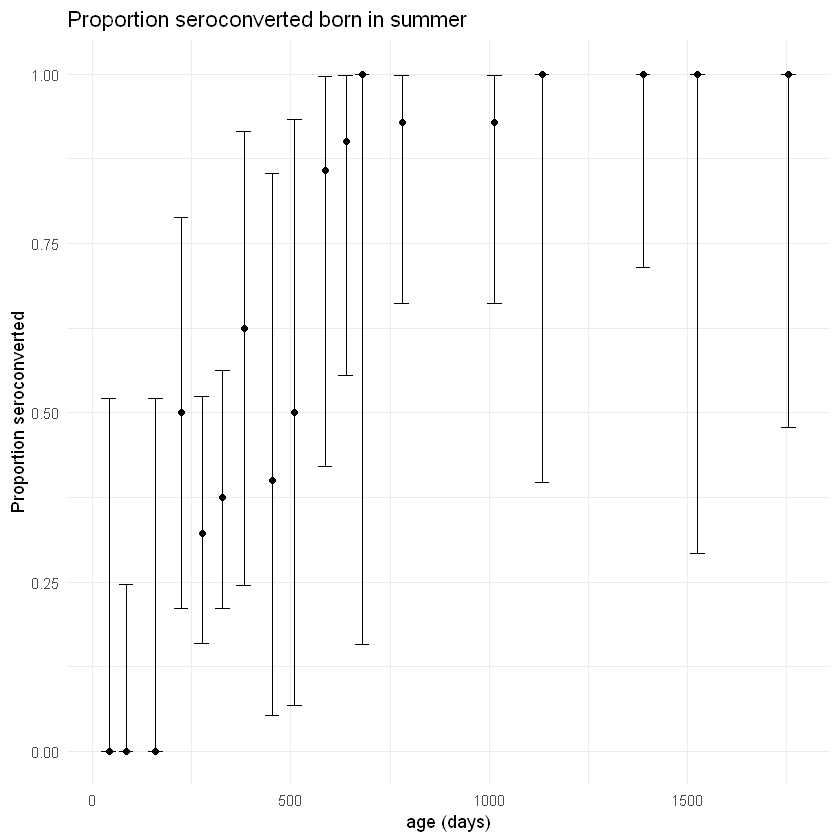

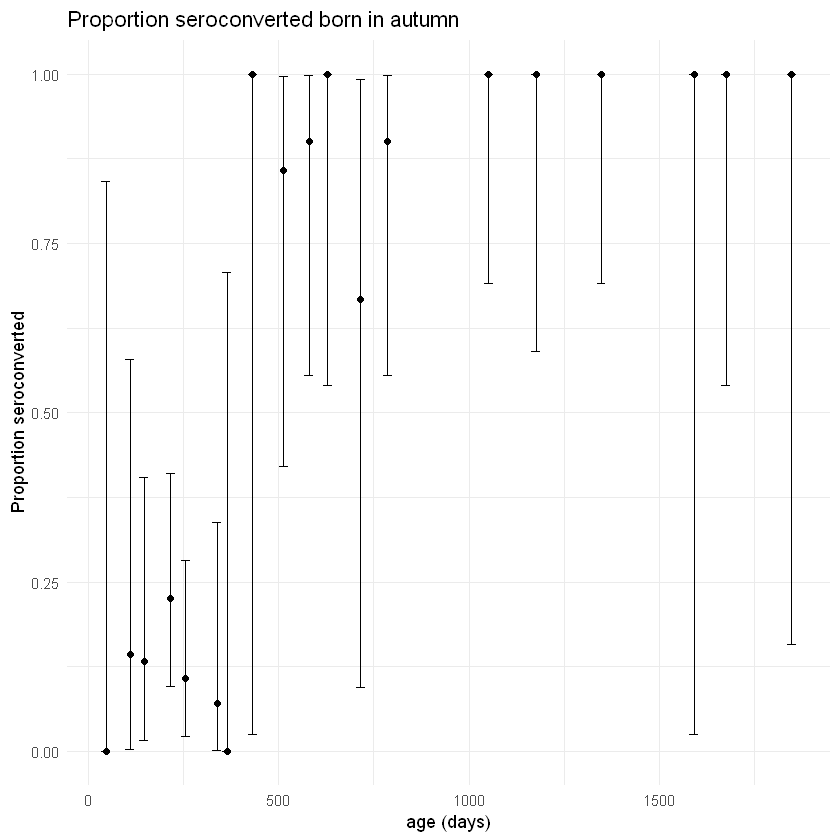

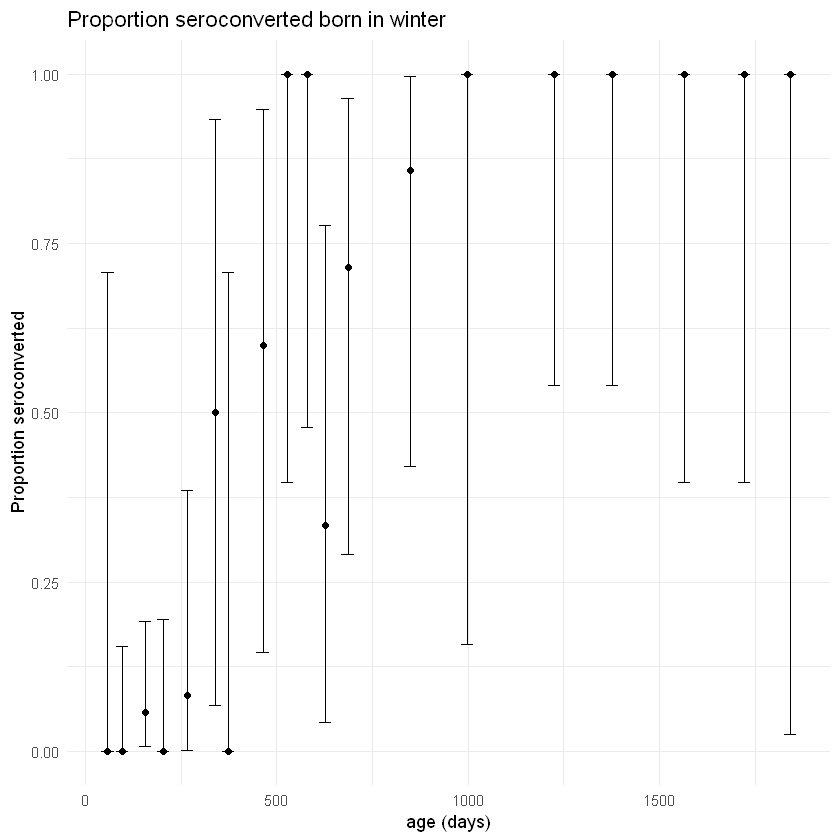

In [10]:
spring.df <- subset(data, season_birth == 'Spring')
ggplot(spring.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in spring")

summer.df <- subset(data, season_birth == 'Summer')
ggplot(summer.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in summer")

autumn.df <- subset(data, season_birth == 'Autumn')
ggplot(autumn.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in autumn")

winter.df <- subset(data, season_birth == 'Winter')
ggplot(winter.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in winter")


## Model equation ##

In [11]:
model <- function(theta, age, inits, data) {
  
  catalytic <- function(age, state, param, data) {
    
    # FOI / seroconversion rate
    # Define booleans to know which season the cohort is in
    spring_FOI_sp = 0
    summer_FOI_sp = 0
    autumn_FOI_sp = 0
    winter_FOI_sp = 0
    spring_FOI_sm = 0
    summer_FOI_sm = 0
    autumn_FOI_sm = 0
    winter_FOI_sm = 0
    spring_FOI_au = 0
    summer_FOI_au = 0
    autumn_FOI_au = 0
    winter_FOI_au = 0
    spring_FOI_wt = 0
    summer_FOI_wt = 0
    autumn_FOI_wt = 0
    winter_FOI_wt = 0
  
      if ( (age <= 30.41*3)                                      # FOI of the season in which the children were born
           || ((age>=365) & (age <= (365+30.41*3))) 
           || ((age >= 2*365) & (age <= (2*365+30.41*3))) 
           || ((age >= 3*365) & (age <= (3*365+30.41*3))) 
           || ((age >= 4*365) & (age <= (4*365+30.41*3))) 
           || ((age >= 5*365) & (age <= (5*365+30.41*3))) ){
          spring_FOI_sp = 1
          summer_FOI_sm = 1
          autumn_FOI_au = 1
          winter_FOI_wt = 1
      } 
      
      if ( (age>30.41*3 & age <=30.41*6 )                       # FOI of the season after the children were born
           || ((age > 365 + 30.41*3) & (age <= (365+30.41*6))) 
           || ((age > 2*365 + 30.41*3) & (age <= (2*365+30.41*6))) 
           || ((age > 3*365 + 30.41*3) & (age <= (3*365+30.41*6))) 
           || ((age > 4*365 + 30.41*3) & (age <= (4*365+30.41*6))) 
           || ((age > 5*365 + 30.41*3) & (age <= (5*365+30.41*6))) ){
          summer_FOI_sp = 1
          autumn_FOI_sm = 1
          winter_FOI_au = 1
          spring_FOI_wt = 1
      } 
      
      if ( (age > 30.41*6 & age <= 30.41*9 )                     # FOI 2 seasons after birth
           || ((age > 365+30.41*6) & (age <= (365+30.41*9))) 
           || ((age > 2*365 + 30.41*6) & (age <= (2*365+30.41*9))) 
           || ((age > 3*365 + 30.41*6) & (age <= (3*365+30.41*9))) 
           || ((age > 4*365 + 30.41*6) & (age <= (4*365+30.41*9))) 
           || ((age > 5*365 + 30.41*6) & (age <= (5*365+30.41*9))) ){
          autumn_FOI_sp = 1
          winter_FOI_sm = 1
          spring_FOI_au = 1
          summer_FOI_wt = 1
      } 
      
      if ( (age > 30.41*9 & age <= 30.41*12 )                     # FOI 3 seasons after birth
           || ((age > 365+30.41*9) & (age <= (365+30.41*12))) 
           || ((age > 2*365 + 30.41*9) & (age <= (2*365+30.41*12))) 
           || ((age > 3*365 + 30.41*9) & (age <= (3*365+30.41*12))) 
           || ((age > 4*365 + 30.41*9) & (age <= (4*365+30.41*12))) 
           || ((age > 5*365 + 30.41*9) & (age <= (5*365+30.41*12))) ){
          winter_FOI_sp = 1
          spring_FOI_sm = 1
          summer_FOI_au = 1
          autumn_FOI_wt = 1
      } 
    
      # FOI for each birth cohort
      lambda_sp = (param[["M"]]+param[["P"]])*spring_FOI_sp + param[["M"]]*summer_FOI_sp + 
                (param[["M"]]+param[["A"]])*autumn_FOI_sp + (param[["M"]]+param[["W"]])*winter_FOI_sp 
                 
    lambda_sm = (param[["M"]]+param[["P"]])*spring_FOI_sm + param[["M"]]*summer_FOI_sm + 
                (param[["M"]]+param[["A"]])*autumn_FOI_sm + (param[["M"]]+param[["W"]])*winter_FOI_sm 
                
    lambda_au = (param[["M"]]+param[["P"]])*spring_FOI_au + param[["M"]]*summer_FOI_au + 
                (param[["M"]]+param[["A"]])*autumn_FOI_au + (param[["M"]]+param[["W"]])*winter_FOI_au 
                
    lambda_wt = (param[["M"]]+param[["P"]])*spring_FOI_wt + param[["M"]]*summer_FOI_wt +
                 (param[["M"]]+param[["A"]])*autumn_FOI_wt + (param[["M"]]+param[["W"]])*winter_FOI_wt 
                
    
    # waning maternal immunity, same for all children
    mu = param[["B"]] 
    
    # states 
    # proportion with maternal immunity
    M_sp = exp(state[1]) # born in spring
    M_sm = exp(state[2]) # born in summer
    M_au = exp(state[3]) # born in autumn
    M_wt = exp(state[4]) # born in winter
    # Susceptible
    S_sp = exp(state[5]) # susceptible born in spring
    S_sm = exp(state[6]) # susceptible born in summer
    S_au = exp(state[7]) # susceptible born in autumn
    S_wt = exp(state[8]) # susceptible born in winter
    #Seroconverted
    Z_sp = exp(state[9]) # seroconverted after infection born in spring
    Z_sm = exp(state[10]) # seroconverted after infection born in summer
    Z_au = exp(state[11]) # seroconverted after infection born in autumn
    Z_wt = exp(state[12]) # seroconverted after infection born in winter
    #Z_all = exp(state[13]) # all seroconverted
    
      
    
    # changes in states
    dM_sp = -mu*M_sp
    dM_sm = -mu*M_sm
    dM_au = -mu*M_au
    dM_wt = -mu*M_wt
    dS_sp = + mu*M_sp - lambda_sp*S_sp 
    dS_sm = + mu*M_sm - lambda_sm*S_sm 
    dS_au = + mu*M_au - lambda_au*S_au
    dS_wt = + mu*M_wt - lambda_wt*S_wt
    dZ_sp = + lambda_sp*S_sp
    dZ_sm = + lambda_sm*S_sm 
    dZ_au = + lambda_au*S_au
    dZ_wt = + lambda_wt*S_wt
    
    #dZ_all = + lambda_sp*S_sp + lambda_sm*S_sm + lambda_au*S_au + lambda_wt*S_wt
    
    
    return(list(c(dM_sp/M_sp,dM_sm/M_sm, dM_au/M_au, dM_wt/M_wt,
                  dS_sp/S_sp, dS_sm/S_sm, dS_au/S_au, dS_wt/S_wt,   
                  dZ_sp/Z_sp, dZ_sm/Z_sm, dZ_au/Z_au, dZ_wt/Z_wt), 
                  #dZ_all/Z_all), 
                lambda_sp=lambda_sp, lambda_sm = lambda_sm, 
                lambda_au = lambda_au, lambda_wt = lambda_wt,
                mu=mu))
    
    
  }
  
traj <- data.frame(ode(y=c(M_sp=log(inits[["M_sp"]]),
                             M_sm=log(inits[["M_sm"]]),
                             M_au=log(inits[["M_au"]]),
                             M_wt=log(inits[["M_wt"]]),
                             S_sp=log(inits[["S_sp"]]),
                             S_sm=log(inits[["S_sm"]]),
                             S_au=log(inits[["S_au"]]),
                             S_wt=log(inits[["S_wt"]]),
                             Z_sp=log(inits[["Z_sp"]]),
                             Z_sm=log(inits[["Z_sm"]]),
                             Z_au=log(inits[["Z_au"]]),
                             Z_wt=log(inits[["Z_wt"]])),
                             #Z_all = log(inits[["Z_all"]])),
                         times=age, 
                         func=catalytic, 
                         parms=theta, 
                         data = data,
                         method="lsoda",
                         verbose=F))
  
  #traj$conv <- exp(traj$Z_all) # cumulative seroconversion (=observed state)
  #traj$inc <- c(inits[["Z_all"]], diff(exp(traj$Z_all))) # incident seroconversion
  traj$conv_spring <- exp(traj$Z_sp) # cumulative seroconversion in spring cohort (=observed state)
  traj$inc_spring <- c(inits[["Z_sp"]], diff(exp(traj$Z_sp))) # incident seroconversion
  traj$conv_summer <- exp(traj$Z_sm) # cumulative seroconversion in summer cohort (=observed state)
  traj$inc_summer <- c(inits[["Z_sm"]], diff(exp(traj$Z_sm))) # incident seroconversion
  traj$conv_autumn <- exp(traj$Z_au) # cumulative seroconversion in autumn cohort (=observed state)
  traj$inc_autumn <- c(inits[["Z_au"]], diff(exp(traj$Z_au))) # incident seroconversion
  traj$conv_winter <- exp(traj$Z_wt) # cumulative seroconversion in winter cohort (=observed state)
  traj$inc_winter <- c(inits[["Z_wt"]], diff(exp(traj$Z_wt))) # incident seroconversion
  traj$Z_all = 0.26*traj$Z_sp + 0.29*traj$Z_sp + 0.24*traj$Z_sp + 0.20*traj$Z_sp
  traj$conv <- exp(traj$Z_all)
  return(traj)
  
}

## Trajectory simulation ##

In [12]:
# This function draws n samples from the posterior to calculate the posterior predictive uncertainty (95%)

maketrajsim <- function(trace, theta, age, model, inits, ndraw, data) {
  
  #Draw n fitted parameter vectors theta from the MCMC object
  sample <- getSample(trace, parametersOnly = TRUE, thin=1, numSamples=ndraw) #trace is a sampler, parametersOnly = T means that likelihood, posterior and prior values are not provided in the output, thin = thinning parameter
  
  traj.rep <- adply(.data=sample, .margins=1, .progress="text", .parallel=F, .fun=function(x) { #split sample by 1 = rows and apply function
    
    #Define the theta as the estimated parameters from the current draw and the fixed parameters
    theta.sample <- c(x, theta[!is.na(theta)])
    
    #Simulate trajectory for selected theta
    traj <- match.fun(model)(theta.sample, age, inits, data) #match.fun extracts the underlying function
    traj <- cbind(as.data.frame(t(x)), traj)
  })
  
  colnames(traj.rep)[1] <- "replicate"
  return(traj.rep)
  
}

In [13]:
# THETA ---------------------------------------------------------

# P = mean FOI (proportion infected per day) for children born in spring
# M = mean FOI for children born in summer
# A = mean FOI for children born in autumn
# W = mean FOI for children born in winter
# B = rate of waning maternal immunity
theta <- c(P=0.00002, M=0.02001, A=0.00003, W=0.00004, B = 0.01) # these are just random values, to be fitted

# INITS ---------------------------------------------------------

#Should this add up to 1?
inits <- c(M_sp=(1-2*1e-12), M_sm = (1-2*1e-12), M_au= (1-2*1e-12), M_wt = (1-2*1e-12),
           S_sp=1e-12, S_sm=1e-12, S_au=1e-12, S_wt=1e-12, 
           Z_sp = 1e-12, Z_sm=1e-12, Z_au=1e-12, Z_wt=1e-12,
           Z_all = 1e-12) # initial conditions for the states (as proportions)
# --> since we integrate on a log-scale, the initial conditions cannot be 0 (not defined on a log-scale)

# SIMULATION TIME  ---------------------------------------------------------
data <- arrange(data, agemid)
agepred <- data$agemid

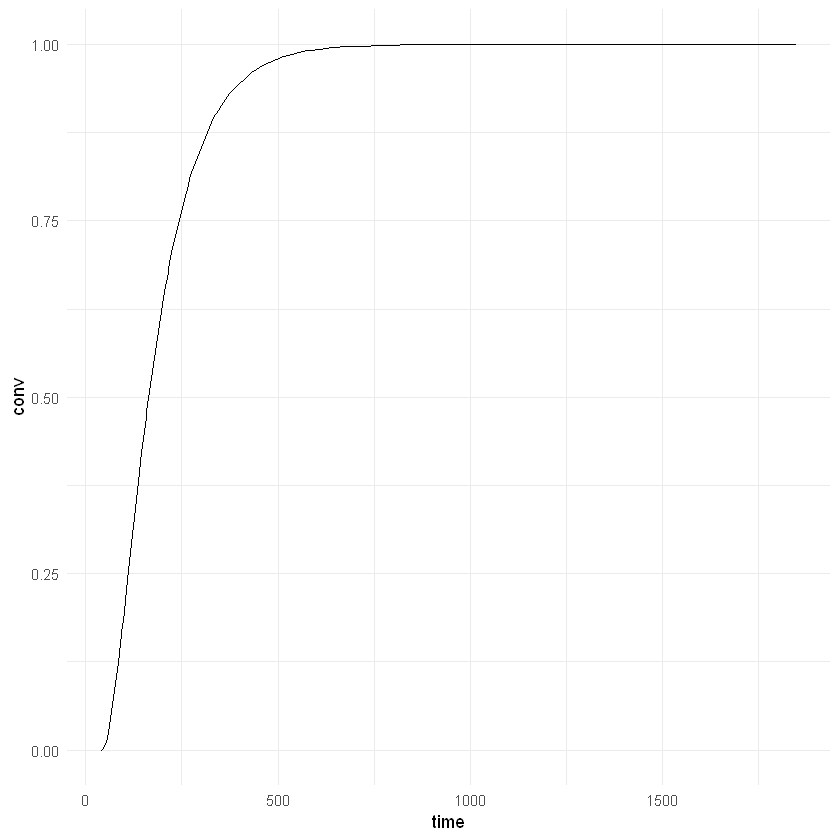

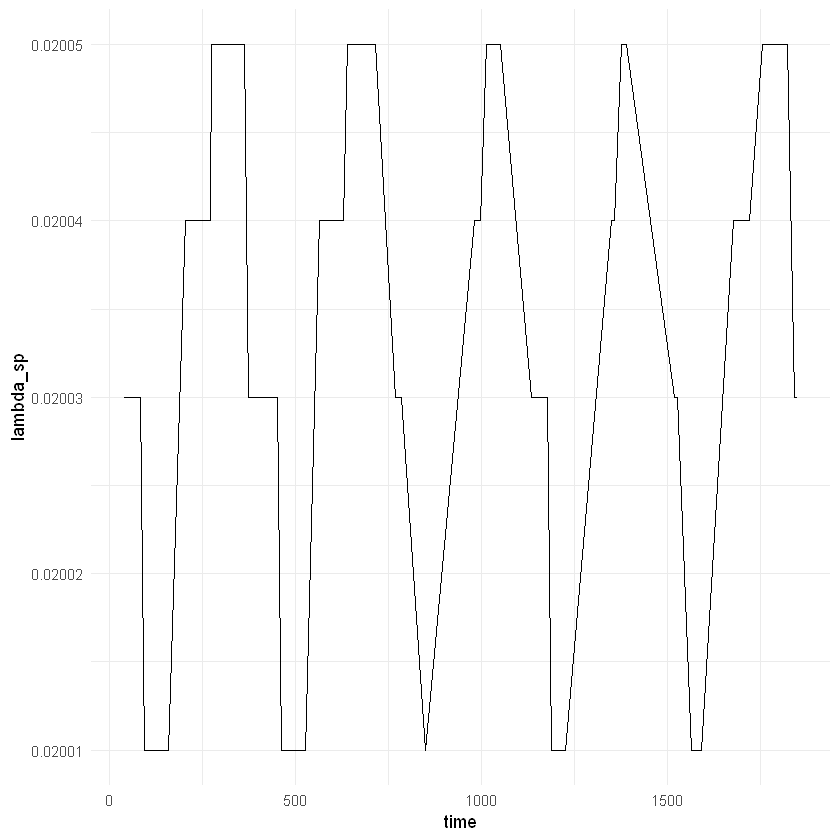

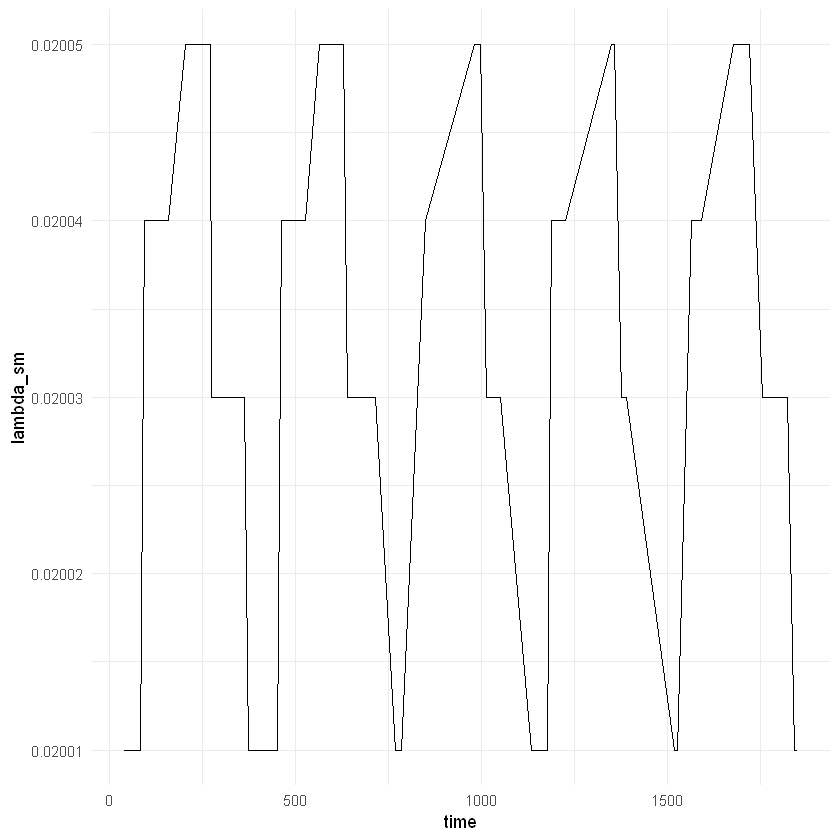

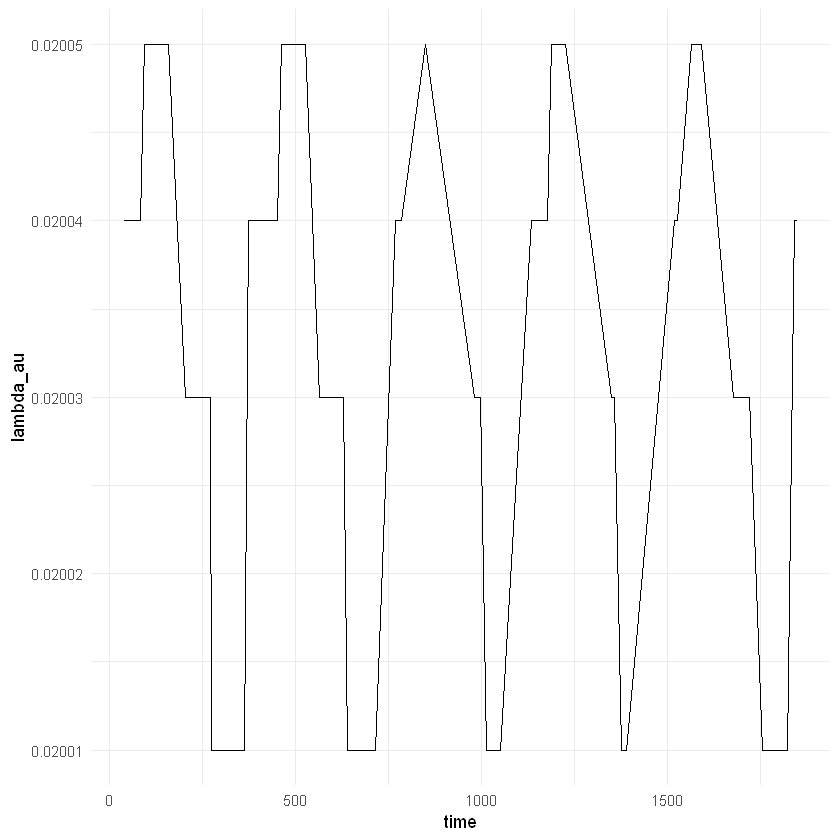

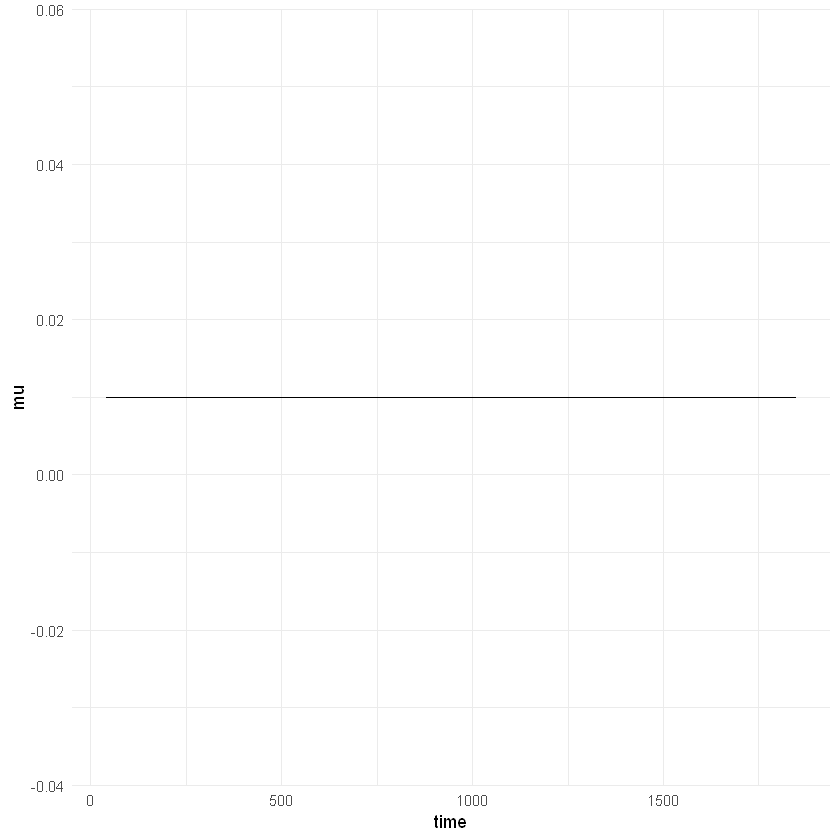

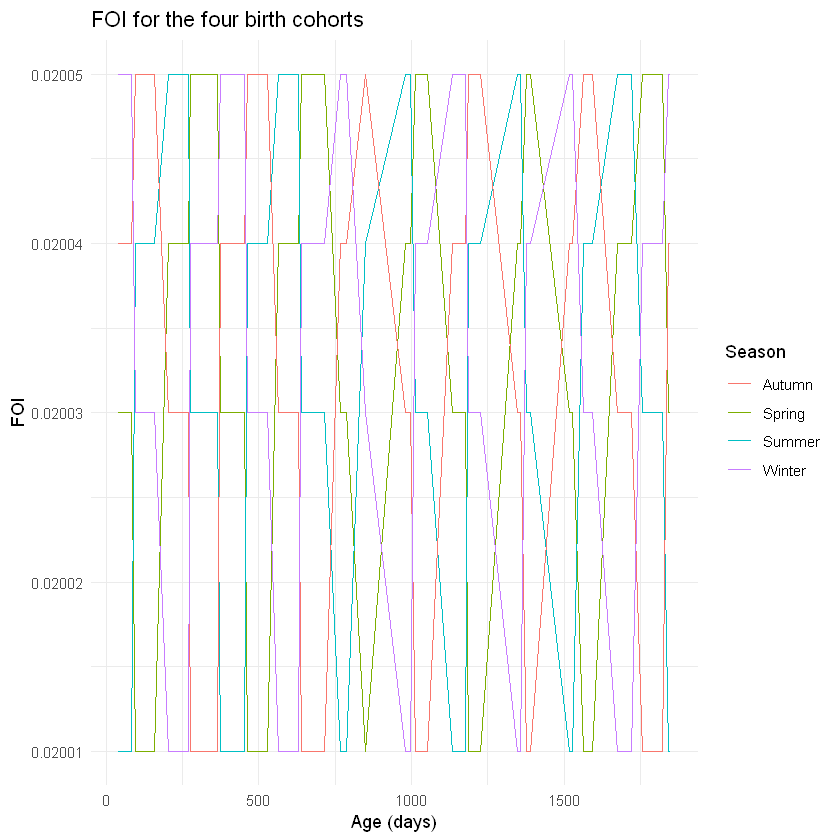

In [14]:
# TEST MODEL  --------------------------------------------------------
test <- model(theta, agepred, inits, data)
ggplot(test) + geom_line(aes(x=time, y=conv))
ggplot(test) + geom_line(aes(x=time, y=lambda_sp)) #should vary
ggplot(test) + geom_line(aes(x=time, y=lambda_sm))
ggplot(test) + geom_line(aes(x=time, y=lambda_au))
ggplot(test) + geom_line(aes(x=time, y=mu))

ggplot(test) + geom_line(aes(x=time, y=lambda_sp, color = 'Spring')) + 
  geom_line(aes(x=time, y=lambda_sm, color = 'Summer')) + 
  geom_line(aes(x=time, y=lambda_au, color = 'Autumn')) + 
  geom_line(aes(x=time, y=lambda_wt, color = 'Winter')) +  
  xlab("Age (days)") + ylab("FOI") + ggtitle("FOI for the four birth cohorts") +
  labs(color = 'Season')

In [15]:
# LOG LIKELIHOOD FUNCTION ---------------------------------------------------------

loglik <- function(theta, age, data, model, inits) {
    
 traj <- match.fun(model)(theta, age, inits)   
  
  # Whole data
  nconv <- data$nconv[!is.na(data$nconv)] # n seroconverted at each age point  (data)
  N <- data$N[!is.na(data$nconv)] # total N at each age point  (data) 
  prob <- traj$conv[traj$time %in% data$agemid] # proportion seroconverted at each age point (model output)
  
  ll_all <- sum(dbinom(x=nconv,
                   size=N,
                   prob=prob,
                   log=TRUE), na.rm=TRUE)
  
  # Spring birth cohort
  spring_cohort <- subset(data, season_birth == "Spring")
  nconv_sp <- spring_cohort$nconv[!is.na(spring_cohort$nconv)] # n seroconverted at each age point  (data)
  N_sp <- spring_cohort$N[!is.na(spring_cohort$nconv)] # total N at each age point  (data) 
  prob_sp <- traj$conv_spring[traj$time %in% spring_cohort$agemid] # proportion seroconverted at each age point (model output)
  
  ll_sp <- sum(dbinom(x=nconv_sp,
                      size=N_sp,
                      prob=prob_sp,
                      log=TRUE), na.rm=TRUE)
  
  #Summer birth cohort
  summer_cohort <- subset(data, season_birth == "Summer")
  nconv_sm <- summer_cohort$nconv[!is.na(summer_cohort$nconv)] # n seroconverted at each age point  (data)
  N_sm <- summer_cohort$N[!is.na(summer_cohort$nconv)] # total N at each age point  (data) 
  prob_sm <- traj$conv_summer[traj$time %in% summer_cohort$agemid] # proportion seroconverted at each age point (model output)
  
  ll_sm <- sum(dbinom(x=nconv_sm,
                      size=N_sm,
                      prob=prob_sm,
                      log=TRUE), na.rm=TRUE)
  
  #Autumn birth cohort
  autumn_cohort <- subset(data, season_birth == "Autumn")
  nconv_au <- autumn_cohort$nconv[!is.na(autumn_cohort$nconv)] # n seroconverted at each age point  (data)
  N_au <- autumn_cohort$N[!is.na(autumn_cohort$nconv)] # total N at each age point  (data) 
  prob_au <- traj$conv_autumn[traj$time %in% autumn_cohort$agemid] # proportion seroconverted at each age point (model output)
  
  ll_au <- sum(dbinom(x=nconv_au,
                      size=N_au,
                      prob=prob_au,
                      log=TRUE), na.rm=TRUE)
  
  # Winter birth cohort
  winter_cohort <- subset(data, season_birth == "Winter")
  nconv_wt <- winter_cohort$nconv[!is.na(winter_cohort$nconv)] # n seroconverted at each age point  (data)
  N_wt <- winter_cohort$N[!is.na(winter_cohort$nconv)] # total N at each age point  (data) 
  prob_wt <- traj$conv_winter[traj$time %in% winter_cohort$agemid] # proportion seroconverted at each age point (model output)
  
  ll_wt <- sum(dbinom(x=nconv_wt,
                      size=N_wt,
                      prob=prob_wt,
                      log=TRUE), na.rm=TRUE)
  
  ll = sum(ll_sp, ll_sm, ll_au, ll_wt)
  
  return(ll_all)
  
} 

# Test function
loglik(theta, agepred, data, model, inits)

[1] -360.7645

In [16]:
# Wrapper for BT: loglik can only take the fitted parameters as argument
loglik_wrapper <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik(theta = parX,
                age = agepred, 
                data = data,
                model = match.fun(model),
                inits = inits))
} 

## Fitting ##

In [17]:
# Estimated params
estpars <- c("P", "M", "A", "W", "B") # parameters to estimate, can be modified
index <- which(names(theta) %in% estpars) # index of estimated params


# Priors
lower = c(P=0, M=0, A=0, W=0, B = 0)
upper = c(P=0.1, M=0.1, A=0.1, W = 0.1, B = 0.2)

prior <- createUniformPrior(lower=lower[estpars], 
                            upper=upper[estpars])
# MCMC settings
nchains <- 2
cpus <- 1 # or 2 if you want parallel, but it does not seem to be faster?
mcmc_settings <- list(iterations = 2*80000, 
                      nrChains = nchains)
sampler <- "Metropolis"

if (cpus == 1) {
  bayesianSetup <- createBayesianSetup(prior = prior,
                                       likelihood = loglik_wrapper,
                                       names = names(theta[index]),
                                       parallel = FALSE)
  
  system.time({trace <- runMCMC(bayesianSetup = bayesianSetup, 
                                sampler = sampler, 
                                settings = mcmc_settings)})
  
}

BT runMCMC: trying to find optimal start and covariance values

BT runMCMC: Optimization finished, setting startValues to 0.000599418346731663 7.50952163001827e-07 0.0017850044235865 0.0635948535356299 0.191004217394501  - Setting covariance to 3.08740902573574e-31 0 1.10815598088011e-51 1.7103299625112e-53 -2.6002590367001e-37 0 3.08740902573574e-31 5.69252608176044e-78 0 -5.6087511388492e-60 1.10815598088011e-51 5.69252608176044e-78 3.08740902573574e-31 8.65449507532164e-54 -1.31576535060171e-37 1.7103299625112e-53 0 8.65449507532164e-54 3.08740902573574e-31 -2.03075464248352e-39 -2.6002590367001e-37 -5.6087511388492e-60 -1.31576535060171e-37 -2.03075464248352e-39 3.08740902573574e-23 



runMCMC terminated after 7295.2seconds



BT runMCMC: trying to find optimal start and covariance values

BT runMCMC: Optimization finished, setting startValues to 0.0523463431971226 3.08545823703727e-05 4.39378565986309e-05 0.0867160094633544 0.0995920291337214  - Setting covariance to 5.46662252742896e-08 1.75318455014321e-11 1.22024797571505e-11 -2.87405930038937e-08 -4.62799861098412e-08 1.75318455014321e-11 1.23335985925108e-14 3.2732581113824e-15 1.24133312335816e-11 -4.48679607729175e-11 1.22024797571505e-11 3.2732581113824e-15 4.90345768249549e-15 -9.94283003267341e-12 -5.43409358637829e-12 -2.87405930038937e-08 1.24133312335816e-11 -9.94283003267341e-12 1.34298922259343e-07 -1.41114994167187e-07 -4.62799861098412e-08 -4.48679607729175e-11 -5.43409358637829e-12 -1.41114994167187e-07 2.68837730137739e-07 



runMCMC terminated after 6847.99seconds



    user   system  elapsed 
13996.41   141.03 14143.25 

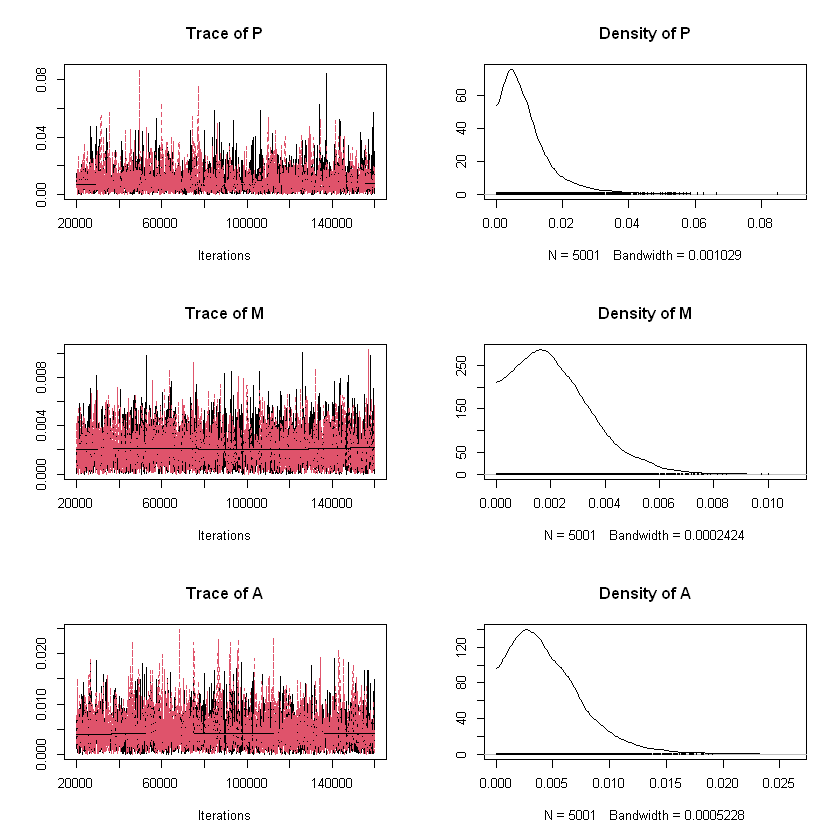

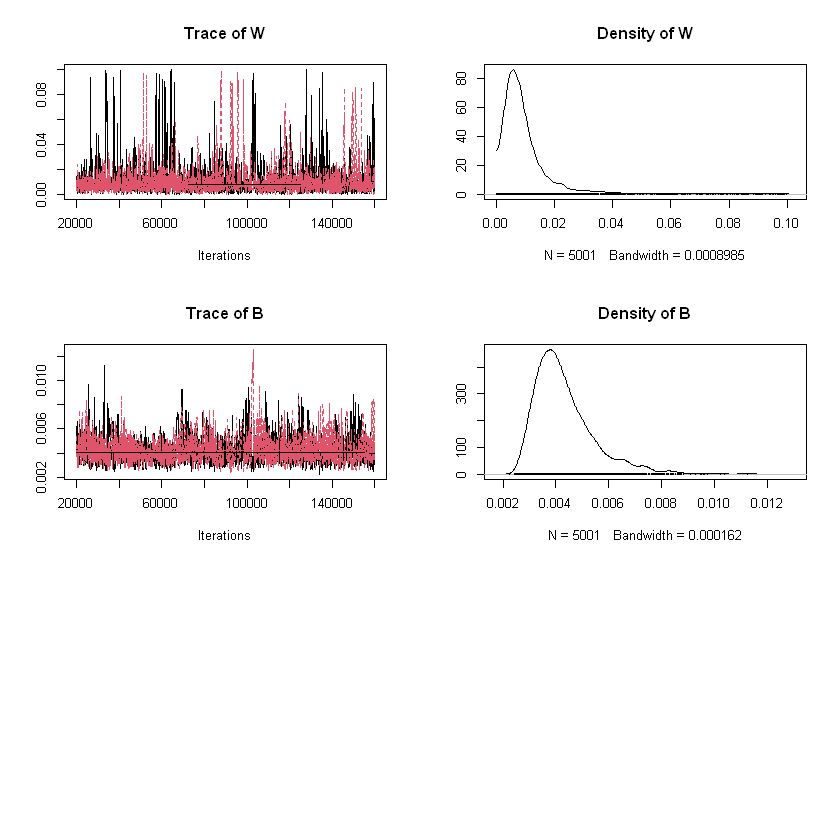

Potential scale reduction factors:

  Point est. Upper C.I.
P       1.01       1.01
M       1.00       1.02
A       1.01       1.01
W       1.00       1.00
B       1.03       1.07

Multivariate psrf

1.01

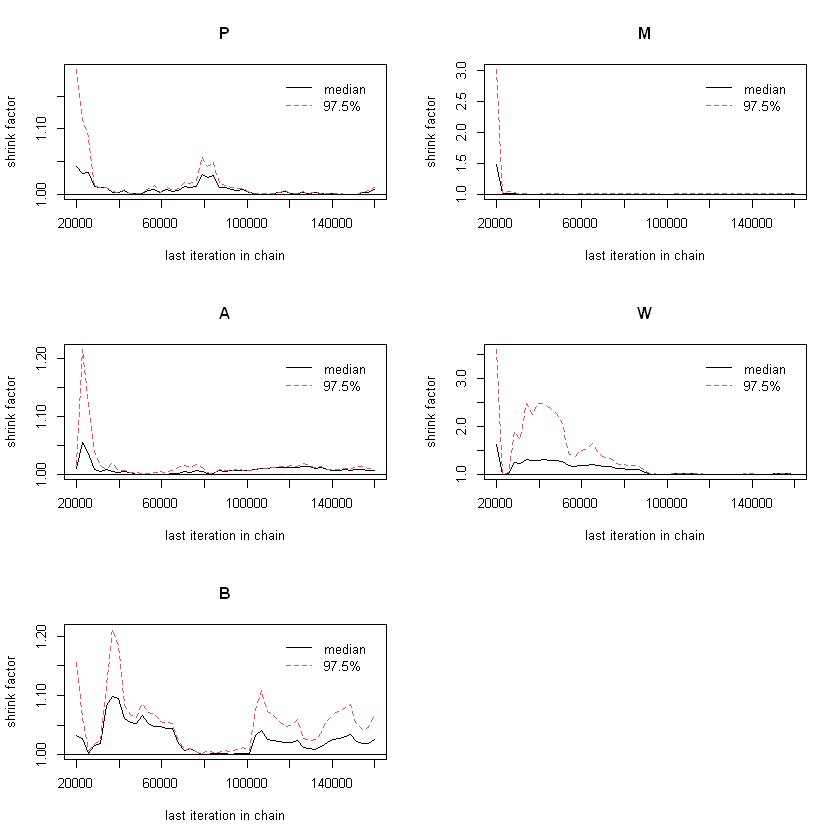

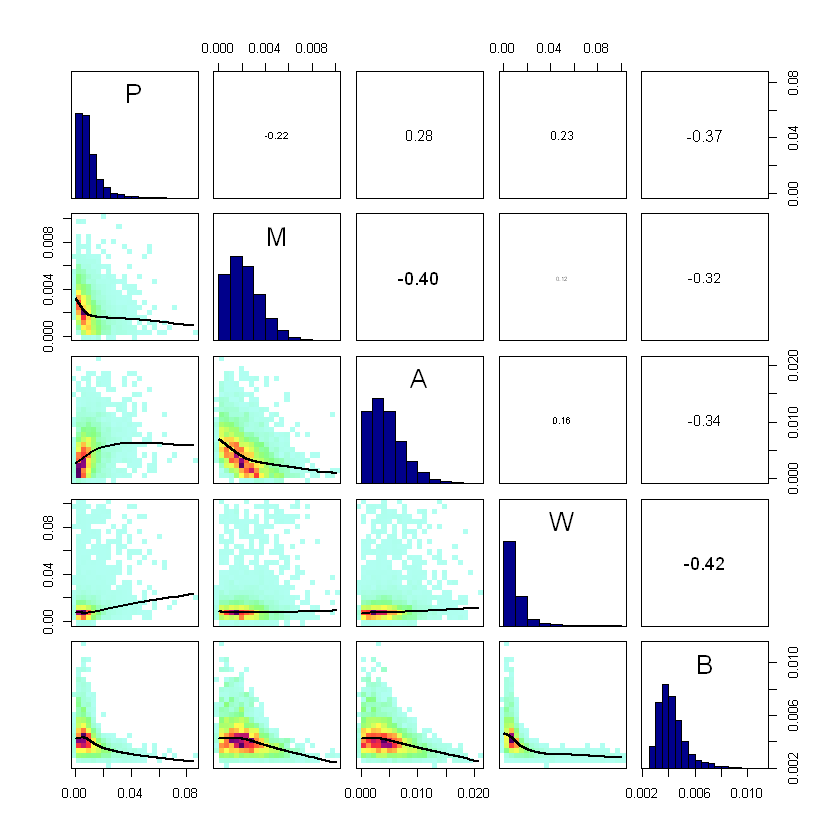

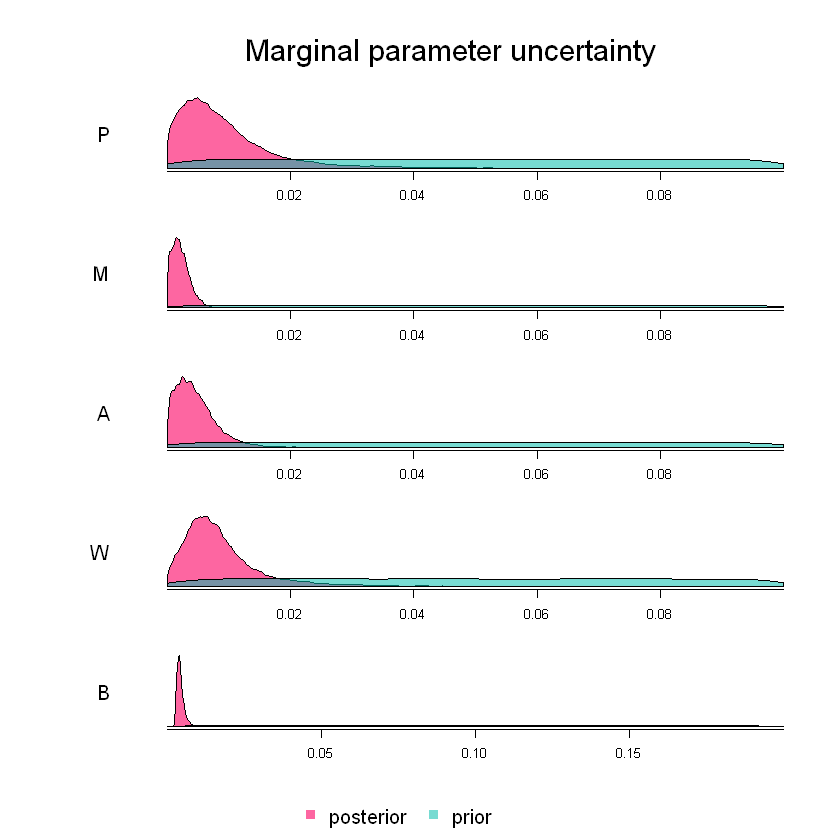

In [20]:
nburn <- 20000
plot(trace, parametersOnly = TRUE, start =nburn)

# check convergence and correlations
gelmanDiagnostics(trace, plot=TRUE, start=nburn)
correlationPlot(getSample(trace, parametersOnly = TRUE, coda=TRUE, start=nburn), density="smooth", thin=50)
marginalPlot(trace, prior=T, singlePanel=T, start=nburn, nDrawsPrior = 1000)

In [21]:
tracefinal <- getSample(trace, parametersOnly = TRUE, coda=TRUE, start=nburn)

In [22]:
trajsim <- maketrajsim(tracefinal, theta, agepred, model, inits, 1000)
trajquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles) <- c("agemid", "low95", "median", "up95")

lambda_spquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"lambda_sp"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_spquantiles) <- c("agemid", "low95", "median", "up95")

lambda_smquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"lambda_sm"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_smquantiles) <- c("agemid", "low95", "median", "up95")

lambda_auquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"lambda_au"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_auquantiles) <- c("agemid", "low95", "median", "up95")

lambda_wtquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"lambda_wt"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_wtquantiles) <- c("agemid", "low95", "median", "up95")

wquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles) <- c("agemid", "low95", "median", "up95")

Pquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"P"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(Pquantiles) <- c("agemid", "low95", "median", "up95")

Mquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"M"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(Mquantiles) <- c("agemid", "low95", "median", "up95")

Aquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"A"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(Aquantiles) <- c("agemid", "low95", "median", "up95")

Wquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"W"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(Wquantiles) <- c("agemid", "low95", "median", "up95")


  |======================================================================| 100%


In [28]:
head(Mquantiles*30.41,1) #proportion exposed per summer month

,agemid,low95,median,up95
,<dbl>,<dbl>,<dbl>,<dbl>
1,1277.22,0.004153795,0.06066136,0.1723403


In [31]:
#proportion exposed per spring month
trajsim$spring_FOI <- (trajsim$P + trajsim$M)*30.41
spring_FOI_quantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"spring_FOI"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(spring_FOI_quantiles) <- c("agemid", "low95", "median", "up95")
head(spring_FOI_quantiles,1)                               

,agemid,low95,median,up95
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,0.1001296,0.2924384,1.107513


In [33]:
#proportion exposed per autumn month
trajsim$autumn_FOI <- (trajsim$A + trajsim$M)*30.41
autumn_FOI_quantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"autumn_FOI"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(autumn_FOI_quantiles) <- c("agemid", "low95", "median", "up95")
head(autumn_FOI_quantiles,1)  

,agemid,low95,median,up95
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,0.08538446,0.1881143,0.4614531


In [34]:
#proportion exposed per winter month
trajsim$winter_FOI <- (trajsim$W + trajsim$M)*30.41
winter_FOI_quantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"winter_FOI"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(winter_FOI_quantiles) <- c("agemid", "low95", "median", "up95")
head(winter_FOI_quantiles,1)

,agemid,low95,median,up95
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,0.08116074,0.298794,1.790433


In [27]:
head(1/wquantiles, 1) #duration of maternal immunity in days

,agemid,low95,median,up95
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.02380952,356.2618,246.1511,141.5942


In [28]:
write.csv(lambda_spquantiles, "mock_S_lambda_sp2.csv")
write.csv(lambda_smquantiles, "mock_S_lambda_sm2.csv")
write.csv(lambda_auquantiles, "mock_S_lambda_au2.csv")
write.csv(lambda_auquantiles, "mock_S_lambda_wt2.csv")

write.csv(Pquantiles, "mock_S_Pquantiles2.csv")
write.csv(Mquantiles, "mock_S_Mquantiles2.csv")
write.csv(Aquantiles, "mock_S_Aquantiles2.csv")
write.csv(Wquantiles, "mock_S_Wquantiles2.csv")
write.csv(wquantiles, "mock_S_Immunity_quantiles2.csv")

write.csv(trajquantiles, "mock_S_trajquantiles2.csv")
write.csv(trajsim, "mock_S_trajsim2.csv")

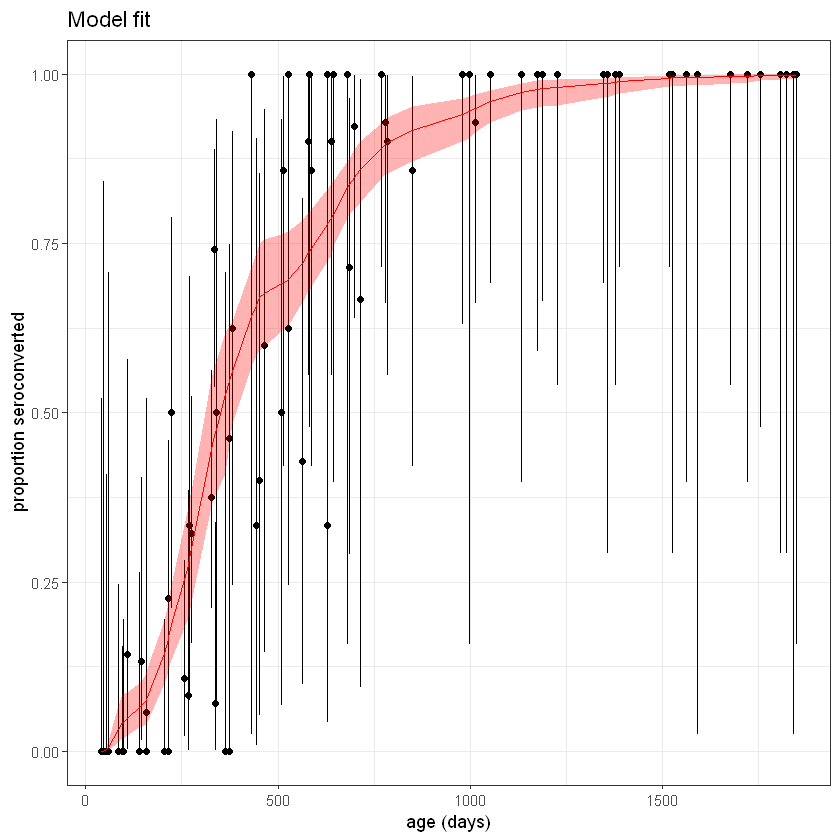

In [35]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit") +
  geom_point(data=data, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=data, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") 

fit

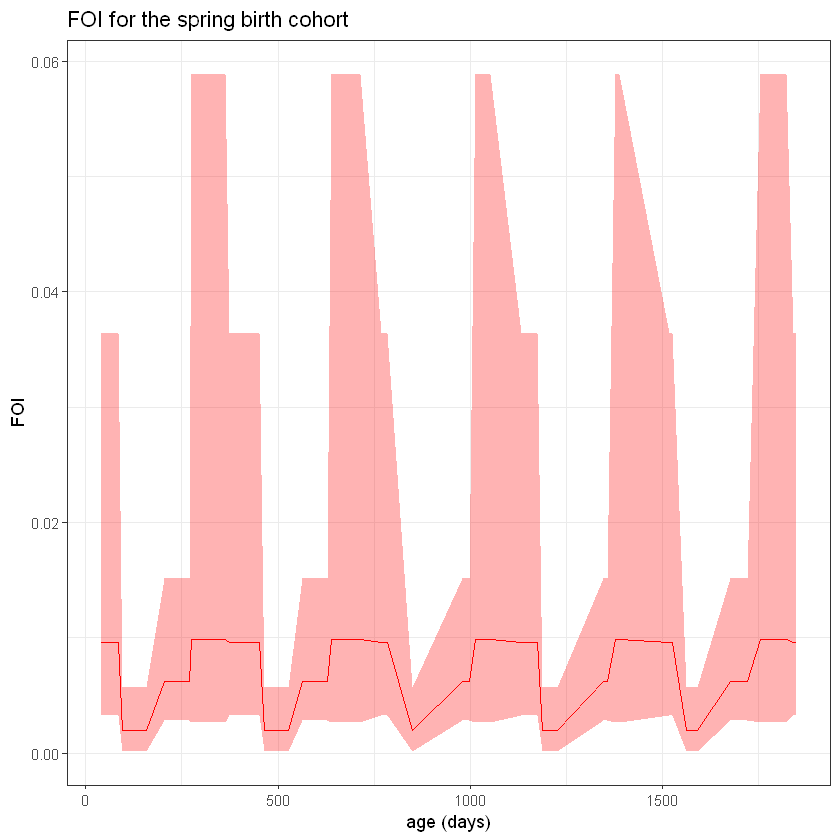

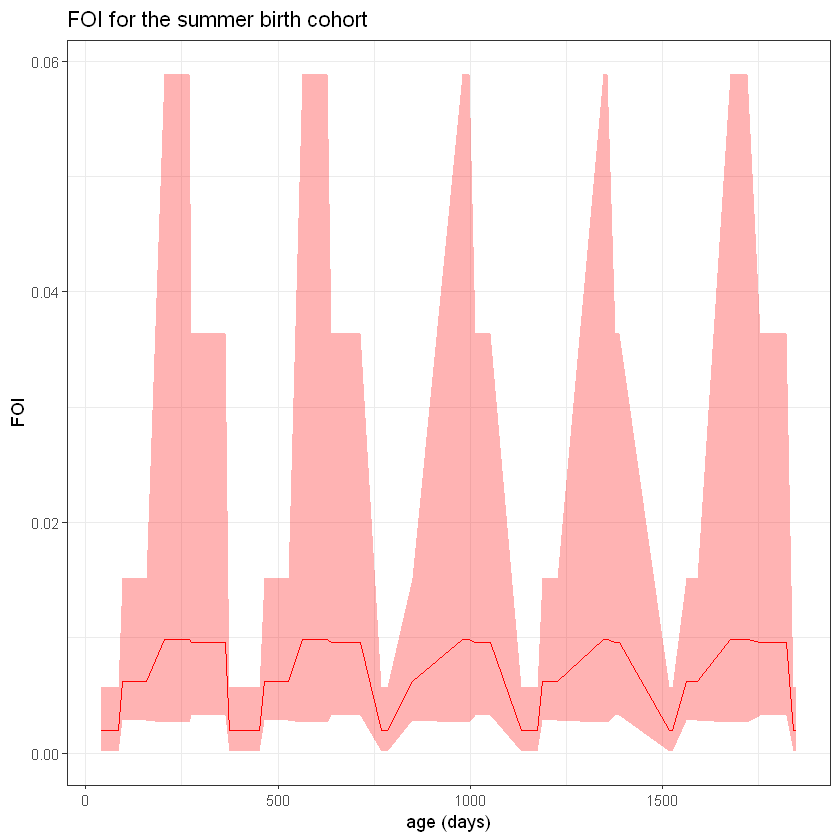

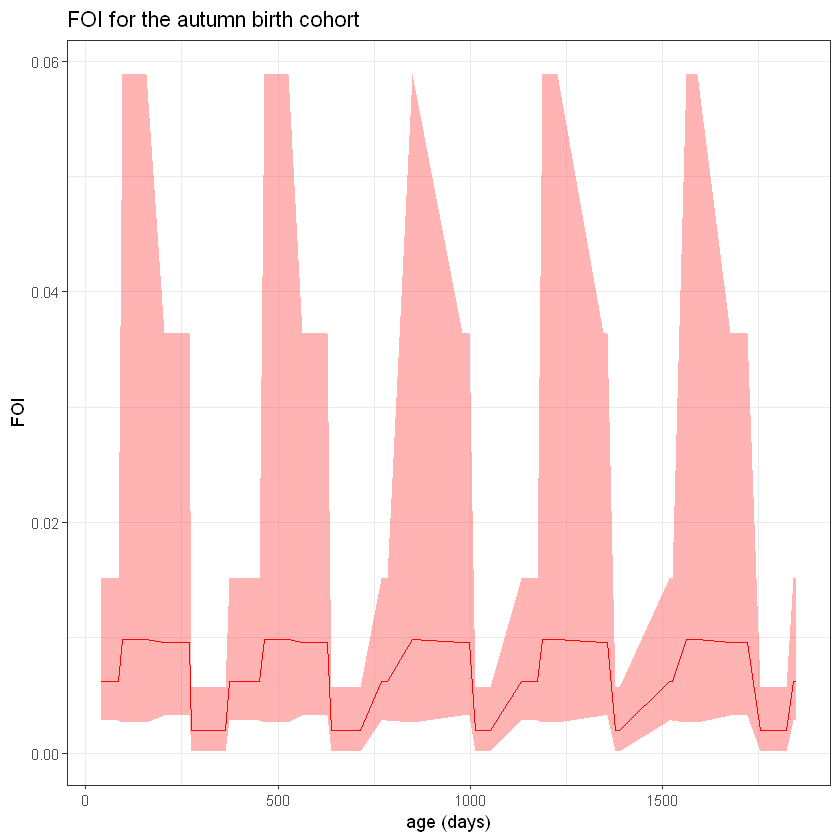

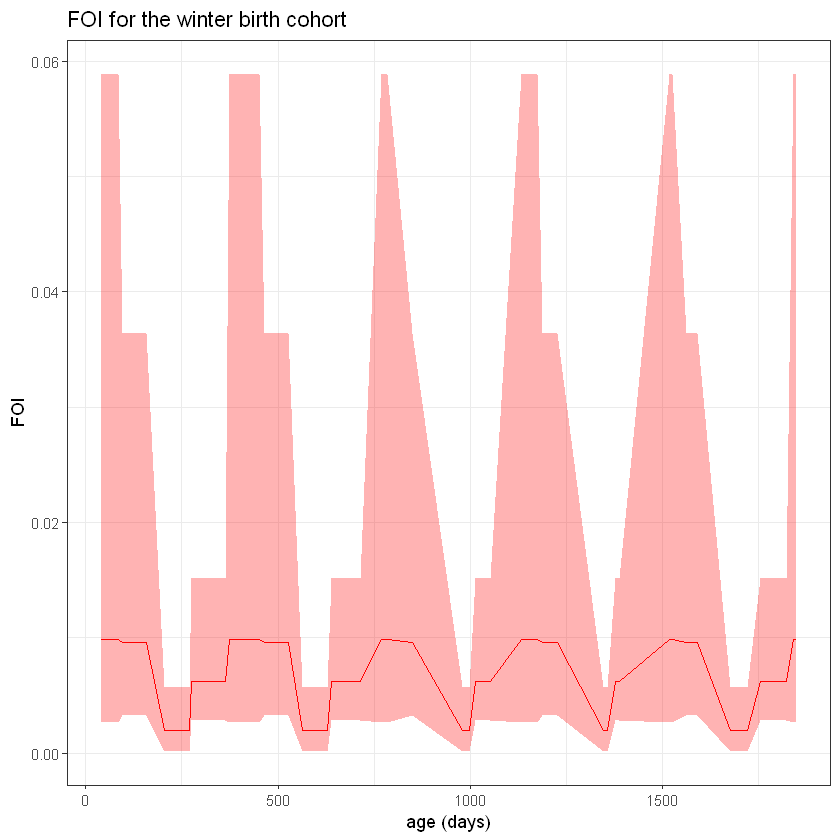

In [36]:
lambda_sp <- ggplot() + theme_bw() + ggtitle("FOI for the spring birth cohort") +
  geom_ribbon(data=lambda_spquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_spquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_sp

lambda_sm <- ggplot() + theme_bw() + ggtitle("FOI for the summer birth cohort") +
  geom_ribbon(data=lambda_smquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_smquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_sm

lambda_au <- ggplot() + theme_bw() + ggtitle("FOI for the autumn birth cohort") +
  geom_ribbon(data=lambda_auquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_auquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_au

lambda_wt <- ggplot() + theme_bw() + ggtitle("FOI for the winter birth cohort") +
  geom_ribbon(data=lambda_wtquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_wtquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_wt

In [37]:
#trajsim2 <- read.csv("mock_S_trajsim2.csv")
spring <- trajsim$spring_FOI
winter <- trajsim$winter_FOI
autumn <- trajsim$autumn_FOI
summer <- trajsim$M

trajsim$ratiowp <- winter/spring
ratio_winter_spring <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratiowp"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

trajsim$ratiowm <- winter/summer
ratio_winter_summer <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratiowm"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

trajsim$ratiowa <- winter/autumn
ratio_winter_autumn <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratiowa"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

trajsim$ratiopm <- spring/summer
ratio_spring_summer <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratiopm"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

trajsim$ratiopa <- spring/autumn
ratio_spring_autumn <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratiopa"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

trajsim$ratioam <- autumn/summer
ratio_autumn_summer <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"ratioam"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 

'#write.csv(ratio_winter_autumn, "mock_ratio_winter_autumn_ll_all.csv")
write.csv(ratio_winter_spring, "mock_ratio_winter_spring_ll_all.csv")
write.csv(ratio_winter_summer, "mock_ratio_winter_summer_ll_all.csv")
write.csv(ratio_autumn_summer, "mock_ratio_autumn_summer_ll_all.csv")
write.csv(ratio_spring_autumn, "mock_ratio_autumn_spring_ll_all.csv")
write.csv(ratio_spring_summer, "mock_ratio_spring_summer_ll_all.csv")#'



[1] "#write.csv(ratio_winter_autumn, \"mock_ratio_winter_autumn_ll_all.csv\")\nwrite.csv(ratio_winter_spring, \"mock_ratio_winter_spring_ll_all.csv\")\nwrite.csv(ratio_winter_summer, \"mock_ratio_winter_summer_ll_all.csv\")\nwrite.csv(ratio_autumn_summer, \"mock_ratio_autumn_summer_ll_all.csv\")\nwrite.csv(ratio_spring_autumn, \"mock_ratio_autumn_spring_ll_all.csv\")\nwrite.csv(ratio_spring_summer, \"mock_ratio_spring_summer_ll_all.csv\")#"

In [38]:
head(ratio_winter_spring, 1)

,time,2.5%,50%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,0.189067,1.048008,5.491336


In [39]:
head(ratio_winter_summer, 1)

,time,2.5%,50%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,38.70875,165.6141,2306.42


In [40]:
head(ratio_winter_autumn, 1)

,time,2.5%,50%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
1,42,0.3658442,1.651391,7.310641
